In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('Data/dataset-case-iqvia.csv', sep=',')

In [4]:
df = df.groupby(['week_dt', 'dsupp_id', 'region_nm'])['units_qty'].sum().reset_index()
df = df[(df['dsupp_id'] == 1) &(df['region_nm'] == 'Sul')]
df['week_dt'] = pd.to_datetime(df['week_dt'])
df = df.sort_values('week_dt')
df.set_index('week_dt', inplace=True)

---

# EDA

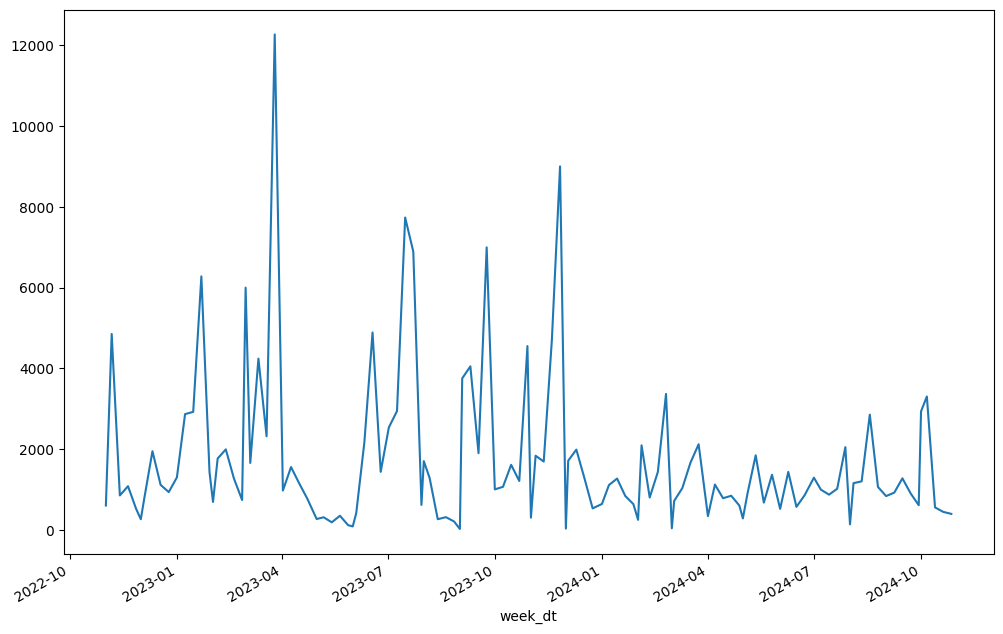

In [5]:
plt.figure(figsize=(12,8))
df['units_qty'].plot()
plt.show()

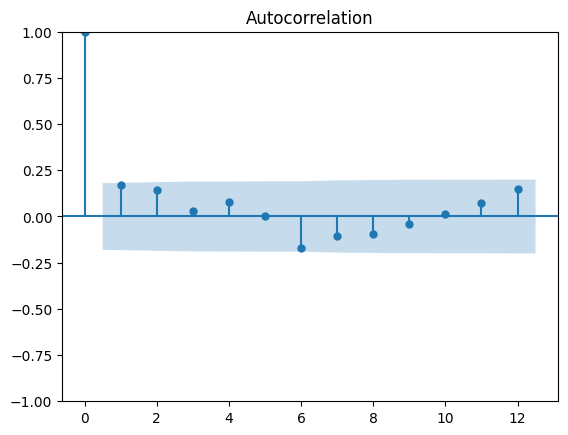

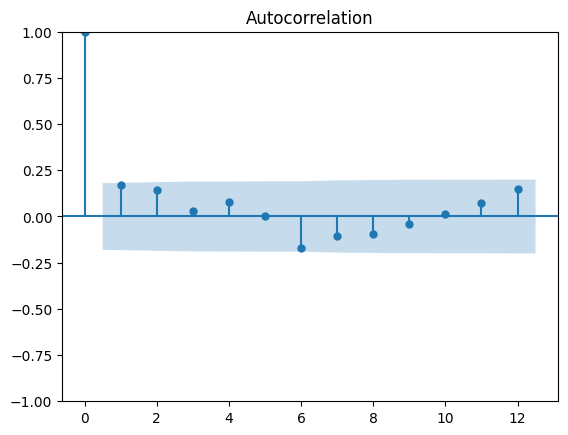

In [6]:
plot_acf(df['units_qty'], lags=12)

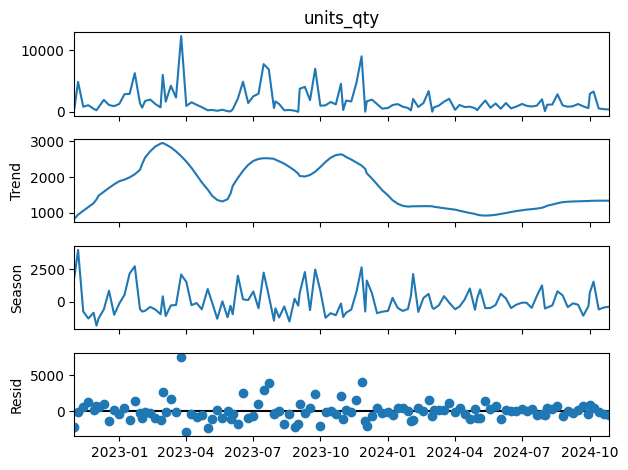

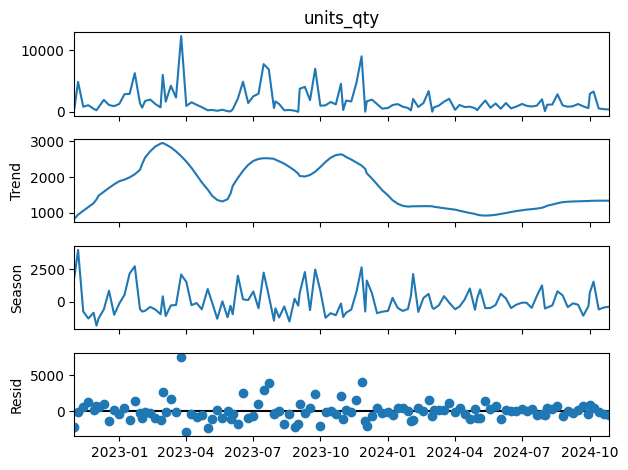

In [7]:
stl = STL(df['units_qty'], period=12)
res = stl.fit()
res.plot()

---

# Sarimax - Região e Distribuidor

In [8]:
df = pd.read_csv('Data/dataset-case-iqvia.csv', sep=',')

In [9]:
df_grouped = df.groupby(['week_dt', 'dsupp_id', 'region_nm'])['units_qty'].sum().reset_index()

In [10]:
def sarimax_group(dsupp_id, region_nm):
    df_filtered = df_grouped[
        (df_grouped['dsupp_id'] == dsupp_id) &
        (df_grouped['region_nm'] == region_nm)
    ].copy()

    df_filtered['week_dt'] = pd.to_datetime(df_filtered['week_dt'])
    df_filtered = df_filtered.sort_values('week_dt')

    df_filtered.set_index('week_dt', inplace=True)

    df_filtered['units_qty'] = df_filtered['units_qty'].fillna(0)

    for lag in [1, 2, 3, 4, 5, 6, 12]:
        df_filtered[f'lag_{lag}'] = df_filtered['units_qty'].shift(lag)
        
    df_filtered['rolling_mean_3'] = df_filtered['units_qty'].shift(1).rolling(window=3).mean()
    df_filtered['rolling_mean_6'] = df_filtered['units_qty'].shift(1).rolling(window=6).mean()
    df_filtered['rolling_std_3'] = df_filtered['units_qty'].shift(1).rolling(window=3).std()
    df_filtered['rolling_std_6'] = df_filtered['units_qty'].shift(1).rolling(window=6).std()

    df_filtered['month'] = df_filtered.index.month
    df_filtered['year'] = df_filtered.index.year
    df_filtered['week'] = df_filtered.index.isocalendar().week.astype(int)

    df_filtered.dropna(inplace=True)

    print(df_filtered.head())

    y = df_filtered['units_qty']
    exog = df_filtered[[
        'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_12',
        'rolling_mean_3', 'rolling_mean_6', 'rolling_std_3', 'rolling_std_6'
    ]]
    
    model = SARIMAX(
        y,
        exog=exog,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 6), 
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    pred = model.fit(disp=False)

    df_filtered['forecast'] = pred.predict(start=0, end=len(df_filtered)-1, exog=exog)

    plt.figure(figsize=(14, 5))
    plt.plot(df_filtered.index, df_filtered['units_qty'], label='Demanda Real', color='black')
    plt.plot(df_filtered.index, df_filtered['forecast'], label='Previsão SARIMAX', color='red', linestyle='--')
    plt.title(f'Demanda Real vs. Prevista - Distribuidor {dsupp_id} | Região {region_nm}')
    plt.xlabel('Data')
    plt.ylabel('Unidades')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pred

            dsupp_id region_nm  units_qty   lag_1   lag_2   lag_3   lag_4  \
week_dt                                                                     
2023-01-15         1       Sul     2924.0  2868.0  1301.0   937.0  1116.0   
2023-01-22         1       Sul     6280.0  2924.0  2868.0  1301.0   937.0   
2023-01-29         1       Sul     1430.0  6280.0  2924.0  2868.0  1301.0   
2023-02-01         1       Sul      693.0  1430.0  6280.0  2924.0  2868.0   
2023-02-05         1       Sul     1769.0   693.0  1430.0  6280.0  2924.0   

             lag_5   lag_6  lag_12  rolling_mean_3  rolling_mean_6  \
week_dt                                                              
2023-01-15  1950.0   784.0   604.0     1702.000000     1492.666667   
2023-01-22  1116.0  1950.0  4854.0     2364.333333     1849.333333   
2023-01-29   937.0  1116.0   854.0     4024.000000     2571.000000   
2023-02-01  1301.0   937.0  1083.0     3544.666667     2623.333333   
2023-02-05  2868.0  1301.0   520.0     2

H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


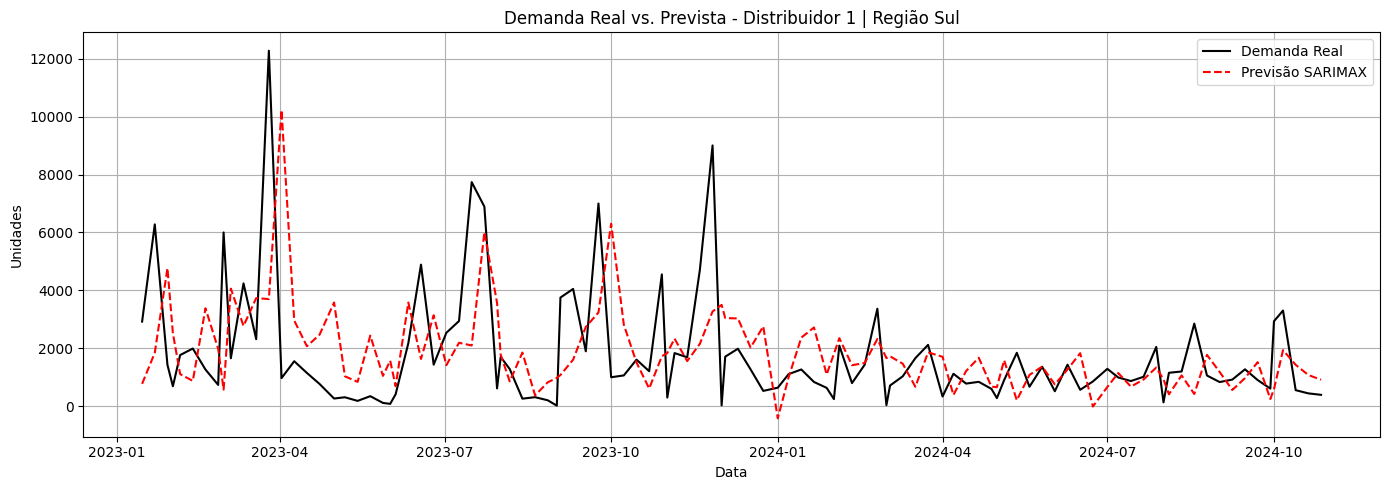

In [11]:
model = sarimax_group(1, 'Sul')